# Tutorial 5 - How to train YOLO on a different dataset
#### This is the fifth tutorial of a series of step-by-step walkthroughs of Yolo algorithm

In this tutorial we are going to do some transfer-learning on a dataset call NFPA dataset, which is used by another fantastic tutorial on YOLO https://timebutt.github.io/static/how-to-train-yolov2-to-detect-custom-objects/  
Please download the data using this link: https://timebutt.github.io/content/other/NFPA_dataset.zip. (~20MB)

In [1]:
from Utilities.io import LoadPascal, label2Box
from Utilities.painter import Visualizer
import tensorflow.keras as tfk
import tensorflow as tf
from YoloBackbone.yolo2 import yoloLoss, raw2Box

import glob, os
import numpy as np

### Step 1. Customized data loader 
The dataset has the following fomrat:  
`NFPA
    |name1.jpg
    |name1.text
        | object category (only 1 class) x y width height (relative to img scale)
    |...
`  
As you can see, the label format isn't exactly what we saw in Pascal Voc. Therefore, the first thing we need to do is to create a customized dataloader function for NFPA by inheriting from the LoadPascal class

In [2]:
class NFPA(LoadPascal):  # inherit from LoadPascal
    # overload the loadData function
    def loadData(self, files, batchSize=4, imgShape=(416, 416, 3), repeat=False, shuffle=False, imgOnly=False):
        if shuffle:
            np.random.shuffle(files)
        imgs = tf.data.Dataset.from_tensor_slices(files)
        data = imgs.map(lambda x: self._preprocess(x, imgShape, imgOnly), 
                       num_parallel_calls=tf.data.experimental.AUTOTUNE)
        data = data.batch(batchSize)
        if repeat:
            data = data.repeat()
        data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return data
    
    # overload the _preprocess function  
    def _preprocess(self, imgName, imgShape, imgOnly=False):
        imgPath = tf.strings.join([self.imgDir, '/', imgName, '.jpg'])
        # load in an image
        img, oriShape = self._decodeJpg(imgPath)
        if imgShape is not None:  # resize an image if imgShape is provided
            img = tf.image.resize(img, imgShape[0: 2])
        else:
            imgShape = oriShape
        if imgOnly:
            return img, imgPath
        # load in the annotation
        annotPath = tf.strings.join([self.annotDir, '/', imgName, '.txt'])
        # utilities like _decodeTxt() are provided by the base class
        label = tf.py_function(self._decodeTxt, inp=[annotPath], Tout=[tf.float32])
        label = tf.squeeze(label, axis=0)
        # from center,w, h to [top left, bottom right] pascal style format
        topLeft = label[..., 1:3] - label[..., 3:4] / 2
        bottomRight = label[..., 1:3] + label[..., 3:4] / 2
        label = tf.concat([label[...,0:1], topLeft, bottomRight], axis=-1)
        label = self._yoloFormat(label, imgShape)     
        # do some image transformations if you like  
        #img = tf.image.random_brightness(img, max_delta=0.2)
        return img, label, imgPath

### Step 2. Train/Test split
Now we are done with the loading scripts, the next step would be train/validation split.

In [3]:
DATA_DIR = 'I:/Data/NFPA_dataset/NFPA dataset'
ANNOT_DIR = DATA_DIR # annotation is under the same dir
ANCHOR_PATH = 'Metadata/PascalVoc12/tinyVocAnchors.txt' # use the voc anchors for simplicity
# only names, without the file extensions
allJpgs = [jpg.split('.')[0] for jpg in os.listdir(DATA_DIR) if jpg.endswith('.jpg')]
np.random.shuffle(allJpgs)
train, val = allJpgs[:int(0.8*len(allJpgs))], allJpgs[int(0.8*len(allJpgs)):]

Now it's time to test our loading function

In [ ]:
loader = NFPA(imgDir=DATA_DIR, annotDir=ANNOT_DIR, anchorPath=ANCHOR_PATH)
IMG_SHAPE = (416, 416, 3) # resize to 416, 416 standard VOC dimension
trainData = loader.loadData(files=train, imgShape=IMG_SHAPE, batchSize=2, shuffle=True)
painter = Visualizer(classNames=['fire diamond'])
for imgs, labels, names in trainData.take(2):
    print(names)
    for img, label in zip(imgs, labels):
        # convert the labels back to a list of boxes for display
        convShape = [IMG_SHAPE[0] // 32, IMG_SHAPE[1]//32]
        bboxList = np.squeeze(label2Box(label, convShape, loader.anchors))
        # box list has shape (num box, 5), the last dimension is 
        # (left, top, bottom, right, obj id) normalized between 0 and 1
        bboxList = bboxList.reshape(-1, 5)
        classList = [int(bbox[0]) for bbox in bboxList]
        # scale the box back to image scale
        bboxList = [ [bbox[1]*IMG_SHAPE[1], bbox[2]*IMG_SHAPE[0],
                      bbox[3]*IMG_SHAPE[1], bbox[4]*IMG_SHAPE[0]] for bbox in bboxList]
        painter.drawBox(img.numpy(), bboxList, classes=classList)


### Load in pretrained YOLO and get the darknet portion
In this tutorial we are using the Tiny YOLO V2 architecture because of the small data size. 
Using the regular YOLO led to inferior performance due to the large number of parameters need calibration.  
I have included the tiny YOLO config file under `Metadata/PascalVoc12`  
For model weights, we want the model to be initialized with darknet-19 weights, which is the feature extractor part of YOLO trained on ImageNet

In [25]:
from YoloBackbone.modelBuilder import YOLO2

CONFIG_PATH = 'Metadata/PascalVoc12/yolo2Tiny.cfg'
# use darknet weights 
WEIGHT_PATH = 'I:/model/YOLO/darknet19_448.conv.23'
builder = YOLO2(configPath=CONFIG_PATH, 
                weightPath=WEIGHT_PATH,
                inputShape=(416, 416, 3),
               transfer=True) # transfer = True -> loads partial weights and randomly initialize the final layers
model, _, _ = builder.buildModel(silence=True)

only darknet weights are loaded!


In [26]:
# let's get rid of the last layer (because we have different number of classes)
NUM_CLASS = 1 # only 1 object -fire diamond
NUM_ANCHORS = 5 # we are using Pascal VOC's anchors just for simplicity
channel = NUM_ANCHORS * (5 + NUM_CLASS)
convOut = tfk.layers.Conv2D(filters=channel, kernel_size=1, strides=1, activation='linear')(model.layers[-2].output)
model = tfk.Model(inputs = model.input, outputs = convOut)

### Training 
Here is the loss function of YOLO, as described in the YOLO V1 paper: https://arxiv.org/pdf/1506.02640.pdf
![Loss](Misc/YoloLoss.jpg) 
YOLO V2 uses lambda coord = 5, lambda nonobj = 1. However, I found this combination of hyperparameters don't work well on our dataset.  
In this example we use: 
* lambda coor = local = 2 
* lambda nonobj = nonObj = 1 
* lambda obj = obj = 6(coefficients of the third term in the loss function, which is by default 1)

In [27]:
#1, 5, 1: okay, maybe more training needed

hyperparam={'local': 2.0, 'obj':6.0, 'nonObj':1.0, 'iouThresh': 0.6}
#hyperparam={'local': 2.0, 'obj':2.0, 'nonObj':0.5}
anchors = loader.anchors

trainData = loader.loadData(files=train, imgShape=IMG_SHAPE, batchSize=32, shuffle=True)
valData = loader.loadData(files=val, imgShape=IMG_SHAPE, batchSize=32, shuffle=True)
# a simple learning rate scheduler
epoch = 0
# according to the original paper. The learning rate should start small,
# increase and then decrease for stability.
def schedule():
    if epoch < 5:
        lr = 5e-5 
    elif epoch < 100:
        lr = 1e-4
    else:
        lr = 6e-5
    return lr

optimizer = tfk.optimizers.Adam(learning_rate=schedule)
trainLog = tfk.metrics.Mean('yolo train loss')
valLog = tfk.metrics.Mean('yolo val loss')

In [ ]:
for _ in range(50):
    for i, (imgs, labels, names) in enumerate(trainData):
        with tf.GradientTape() as tape:
            output = model(imgs, training=True) # activate batch normalization in training 
            l, trainDetail = yoloLoss(output, labels, loader.anchors, hyperparam)
        grad = tape.gradient(l, model.trainable_weights)
        optimizer.apply_gradients(zip(grad, model.trainable_weights))
        # store the loss value 
        trainLog(l)
    print('Epoch {}: train loss = {:.3f}'.format(epoch, trainLog.result().numpy()), end='')
    for i, (imgs, labels, names) in enumerate(valData):
        output = model(imgs, training=True) 
        l, valDetail = yoloLoss(output, labels, loader.anchors, hyperparam)
        # store the loss value 
        valLog(l)
    print('\t validation loss = {:.3f} ...'.format(valLog.result().numpy()))
    print('*-'*20)
    epoch += 1
    # clear the epoch buffer
    trainLog.reset_states()
    valLog.reset_states()

### Test the model

In [29]:
#model = tfk.models.load_model('I:/model/YOLO/tutorial/yolo_NFPA_tiny_1_4_15.h5')

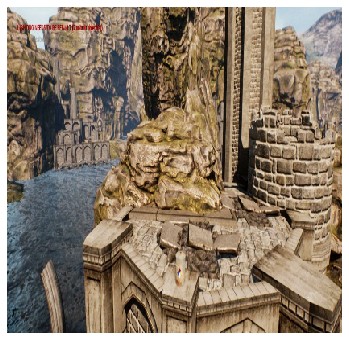

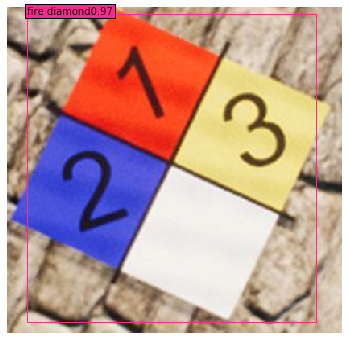

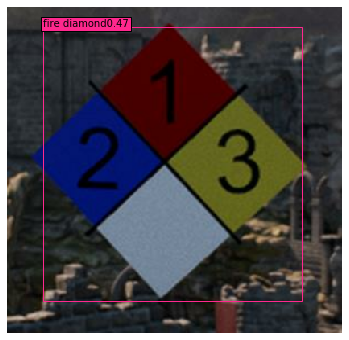

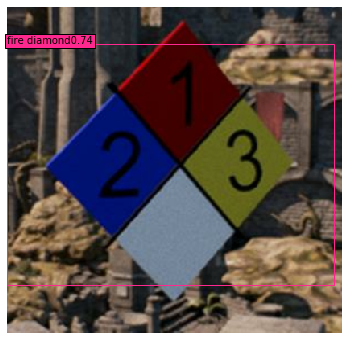

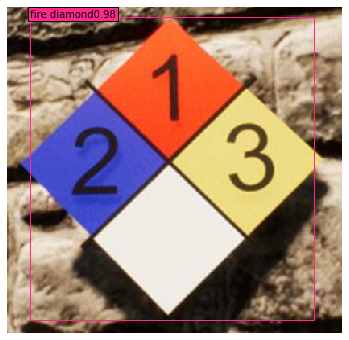

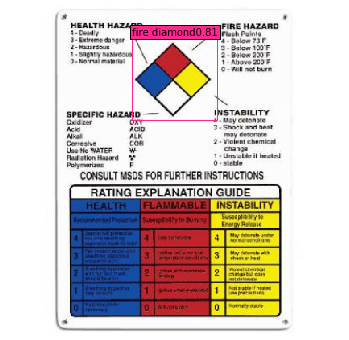

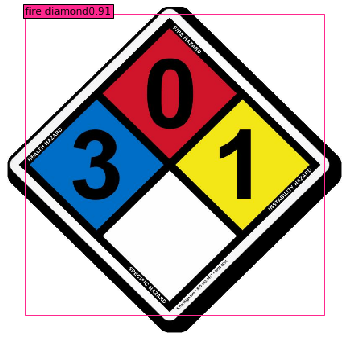

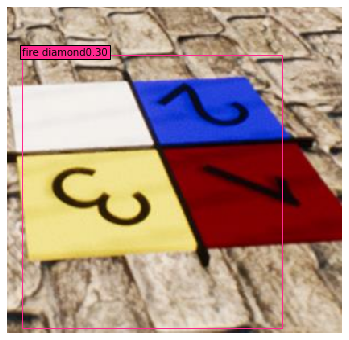

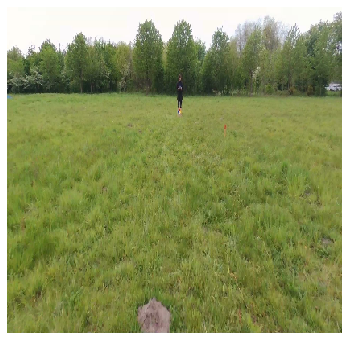

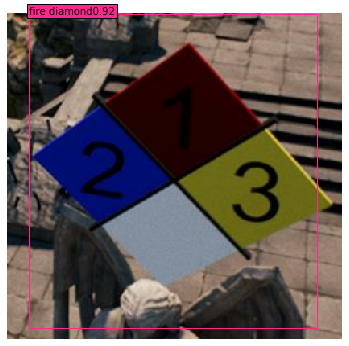

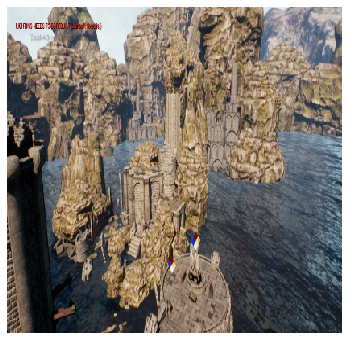

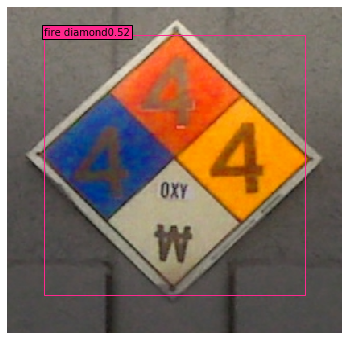

In [47]:
valData = loader.loadData(files=val, imgShape=IMG_SHAPE, batchSize=2, shuffle=True)
anchors = loader.anchors
for imgs, _, names in valData.take(6):
    output = model.predict(imgs)
    # scoreThresh is used to filter out boxes that have low object confidence 
    # iouThresh is used to filter out boxes that overlap too much
    results = raw2Box(output, anchors=loader.anchors, numClass=1,
                     scoreThresh=.3, iouThresh=.2, maxBox=10)
    # iterate through the batch as the painter can only handle one image at a time
    for i , (image, (boxes, scores, classes)) in enumerate(zip(imgs, results)):
        fig = painter.drawBox(image, boxes.numpy(), scores.numpy(), classes.numpy())